In [33]:
import cv2
import time
import math
import random
import datetime
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import IPython.display as display

In [34]:
#block đọc dữ liệu file tọa độ thành phố và trả về ma trận khoảng cách
def readCoordinate(path, ftype='txt'):
    if ftype == 'txt':
        cities = []
        f = open(path)
        for i in f.readlines():
            node_city_val = i.split()
            cities.append([node_city_val[0], float(node_city_val[1]), float(node_city_val[2])])
    else:
        infile = open(path, 'r')
        cities = []
        for i, j in enumerate(infile.readlines()):
            node_city_val = j.split()
            if i > 6 and len(node_city_val) == 3 :
                cities.append([node_city_val[0], float(node_city_val[1]), float(node_city_val[2])])
        infile.close()
    dis_mat = []
    for cityA in cities:
        dis_vec = []
        for cityB in cities:
            dis = ((cityA[1] - cityB[1])**2 + (cityA[2] - cityB[2])**2)**0.5
            dis_vec.append(dis)
        dis_mat.append(dis_vec)
    return cities, dis_mat

#block code đọc đường đi tối ưu
def read_optimize_txt(file_path):
    try:
        with open(file_path, 'r') as file:           
            lines = file.readlines()
            numbers = [int(line.strip()) for line in lines]
            return numbers
    except FileNotFoundError:
        print(f"File '{file_path}' doesn,t exist.")
        return []
    except Exception as e:
        print(f"Error: {e}")
        return []

In [44]:
#chọn file data;
index = 0
#đọc ra file tối ưu
optimal_road = read_optimize_txt('optimization/29Y_TSP_opt.txt')

#tính chi phí (cost) của file tối ưu
def finess(ls):
    cost = 0
    for i in range(1, len(ls)):
        cost += distance_matrix[ls[i] - 1][ls[i - 1] - 1]
    cost += distance_matrix[ls[0] - 1][ls[len(ls) - 1] - 1] 
    return cost

cities, distance_matrix = readCoordinate('coordinate/29Y_TSP.txt')
print(f'NUMBER_CITIES:    {len(distance_matrix)}')
print(f"OPTIMAL_SOLUTION: {finess(optimal_road)}")

NUMBER_CITIES:    29
OPTIMAL_SOLUTION: 9074.148047872843


In [36]:
#Ant Colony Optimization - Done
class Graph(object):
    def __init__(self, cost_matrix: list, rank: int):
        self.matrix = cost_matrix
        self.rank = rank
        self.pheromone = [[1 / (rank * rank) for j in range(rank)] for i in range(rank)]
        #khởi tạo pheromone ban đầu, pheromone ban đầu để những con kiến ban đầu không bị ảnh
        #hưởng quá nhiều bởi pheromone

In [37]:
class ACO(object):
    def __init__(self, ant_count: int, generations: int, alpha: float, beta: float, rho: float, q: int, strategy: int):
        self.Q = q                              #q:
        self.rho = rho                          #rho: tốc độ bay hơi của pheromone sau mỗi thế hệ
        self.beta = beta                        #beta:
        self.alpha = alpha                      #alpha:
        self.ant_count = ant_count              #ant_count: số lượng kiến ảo
        self.generations = generations          #số lượng thế hệ
        self.update_strategy = strategy         #strategy: chiến lược cập nhật pheromone
        
        
    def updatePheromone(self, graph: Graph, ants: list):  #update pheromone sau mỗi thế hệ kiếm ăn
        
        for i, row in enumerate(graph.pheromone):
            for j, col in enumerate(row):
                
                graph.pheromone[i][j] *= (1 - self.rho) #sau mỗi thế hệ, pheromone của mỗi cạnh sẽ giảm đi bằng 1 hệ s
                for ant in ants:
                    graph.pheromone[i][j] += ant.pheromone_each[i][j] # update pheromone thế hệ mới nhất
                    
                    
    def solve(self, graph: Graph):
        best_cost = 1e8
        best_solution = []
        
        for gen in range(self.generations):
            if gen % (self.generations / 20) == 0:
                print(f'Gen {gen} is running...')
                
            ants = [Ant(self, graph) for i in range(self.ant_count)]
            
            for ant in ants:
                for i in range(graph.rank - 1):
                    ant.select_next()
                ant.total_cost += graph.matrix[ant.visited[-1]][ant.visited[0]]
                #quay lại thành phố ban đầu
                if ant.total_cost < best_cost:
                    best_cost = ant.total_cost
                    best_solution = [] + ant.visited
                    
                # update pheromone for each ant;
                ant.update_pheromone_each()
                
            self.updatePheromone(graph, ants)
            #update pheromone local
        return best_solution, best_cost

In [38]:
class Ant(object):
    
    def __init__(self, aco: ACO, graph: Graph):
        self.colony = aco      
        self.graph = graph
        self.total_cost = 0.0
        self.visited = []
        self.pheromone_each = []  # the local increase of pheromone
        self.possible = [i for i in range(graph.rank)]  # nodes which are allowed for the next selection
        self.eta = [[0 if i == j else 1 / graph.matrix[i][j] for j in range(graph.rank)] for i in range(graph.rank)]  # heuristic information
        start = random.randint(0, graph.rank - 1)  # start from any node
        self.visited.append(start)
        self.current = start
        self.possible.remove(start)
        
    def select_next(self): #chọn lựa bước đi tiếp theo cho từng kiến
        denominator = 0
        for i in self.possible: #chỉ xét những thành phố chưa đi qua
            
            denominator += self.graph.pheromone[self.current][i] ** self.colony.alpha * self.eta[self.current][i] ** self.colony.beta
            
        probabilities = [0 for i in range(self.graph.rank)] 
        
        for i in range(self.graph.rank):
            try:
                self.possible.index(i)  # test if allowed list contains i
                probabilities[i] = self.graph.pheromone[self.current][i] ** self.colony.alpha * self.eta[self.current][i] ** self.colony.beta / denominator
                #alpha và beta là các tham số thể hiện nên sự ảnh hưởng của pheromone hoặc thông tin heuristic vào sự lựa chọn của kiến
                
            except ValueError:
                pass  # do nothing
        selected = 0
        rand = random.random()
        for i, probability in enumerate(probabilities):
            rand -= probability
            if rand <= 0:
                selected = i
                break
        self.possible.remove(selected)                                 #loại bỏ thành phố khỏi những thành phố chưa đi 
        self.visited.append(selected)                                  #cho vào list visited
        self.total_cost += self.graph.matrix[self.current][selected]   #update total_cost
        self.current = selected                                        #update thành phố mà kiến đang đứng
                     
    def update_pheromone_each(self):
        
        self.pheromone_each = [[0 for j in range(self.graph.rank)] for i in range(self.graph.rank)]
        #xét ở toàn đồ thị
        
        for _ in range(1, len(self.visited)):
            #trong chuỗi
            i = self.visited[_ - 1]
            j = self.visited[_]
            #các chiến lược update pheromone;
            
            if self.colony.update_strategy == 1:  # ant-quality system: mật độ kiến
                self.pheromone_each[i][j] = self.colony.Q
            elif self.colony.update_strategy == 2:  # ant-density system: số lượng kiến
                self.pheromone_each[i][j] = self.colony.Q / self.graph.matrix[i][j]
            else:  # ant-cycle system
                self.pheromone_each[i][j] = self.colony.Q / self.total_cost

In [39]:
def main():
    st = time.time()
    rank = len(distance_matrix)
    ants = 20
    gen = 500
    alpha = 1
    beta = 10
    rho = 0.5
    q = 1
    strategy = 3
    aco = ACO(ants, gen, alpha, beta, rho, q, strategy)
    graph = Graph(distance_matrix, rank)
    path, cost = aco.solve(graph)
    path.append(path[0])
    print(f'COST: {cost}')
    print(f'PATH: {path}')
    print(f'RUN_TIME: {time.time() - st} sec')
main()

Gen 0 is running...
Gen 25 is running...
Gen 50 is running...
Gen 75 is running...
Gen 100 is running...
Gen 125 is running...
Gen 150 is running...
Gen 175 is running...
Gen 200 is running...
Gen 225 is running...
Gen 250 is running...
Gen 275 is running...
Gen 300 is running...
Gen 325 is running...
Gen 350 is running...
Gen 375 is running...
Gen 400 is running...
Gen 425 is running...
Gen 450 is running...
Gen 475 is running...
COST: 9336.360966758353
PATH: [20, 0, 27, 5, 11, 8, 4, 25, 28, 2, 1, 19, 9, 3, 14, 17, 13, 21, 16, 10, 18, 24, 6, 22, 26, 7, 23, 15, 12, 20]
RUN_TIME: 12.563685417175293 sec


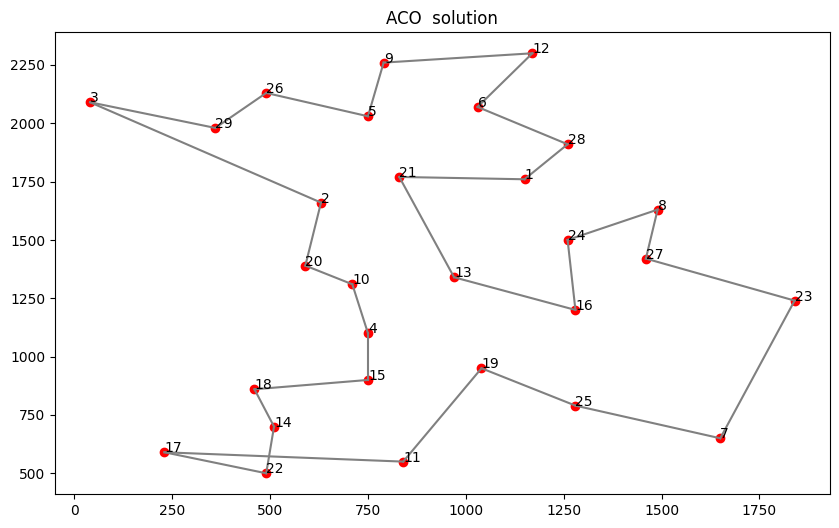

In [43]:
path = [20, 0, 27, 5, 11, 8, 4, 25, 28, 2, 1, 19, 9, 3, 14, 17, 13, 21, 16, 10, 18, 24, 6, 22, 26, 7, 23, 15, 12, 20]

for i in range(len(path)):
    path[i] += 1

def drawMap(city, answer, title=""):
    for j in city:
        plt.plot(j[1], j[2], "ro")
        plt.annotate(j[0], (j[1], j[2]))
    for i in range(len(answer)):
        try:
            first = int(answer[i])
            secend = int(answer[i + 1])
            plt.plot([city[first-1][1], city[secend-1][1]], [city[first-1][2], city[secend-1][2]], "gray")
        except:
            continue
    first = int(answer[0])
    secend = int(answer[-1])
    plt.plot([city[first-1][1], city[secend-1][1]], [city[first-1][2], city[secend-1][2]], "gray")
    plt.title(title)
    plt.show()

fig = plt.figure(figsize=(10, 6))
drawMap(cities, path, f"ACO  solution")